In [643]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [644]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [645]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_complete.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_complete.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")

In [646]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [647]:
column_to_number = {
    'SV1': 1,
    'SV2': 2,
    'SV3': 3,
    'SV4': 4,
}

df_labels['fault_sv'] = 0
df_labels['opening_ratio'] = 100


for index, row in df_labels.iterrows():
    for col in column_to_number.keys():
        if row[col] < 100:
            val=row[col]
            df_labels.at[index, 'fault_sv'] = column_to_number[col]
            df_labels.at[index,'opening_ratio'] = [val]
            break



In [648]:
df_labels["fault_sv"].tail(50)

127    2
128    2
129    3
130    3
131    3
132    3
133    4
134    4
135    4
136    4
137    1
138    1
139    1
140    1
141    2
142    2
143    2
144    2
145    3
146    3
147    3
148    3
149    4
150    4
151    4
152    4
153    0
154    0
155    0
156    0
157    0
158    0
159    0
160    0
161    0
162    0
163    0
164    0
165    0
166    0
167    0
168    0
169    0
170    0
171    0
172    0
173    0
174    0
175    0
176    0
Name: fault_sv, dtype: int64

In [649]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [650]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1,0,100
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1,0,100
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1,0,100
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,0,100


In [651]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [652]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [653]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [654]:
df_train=df_train.drop(columns="index")

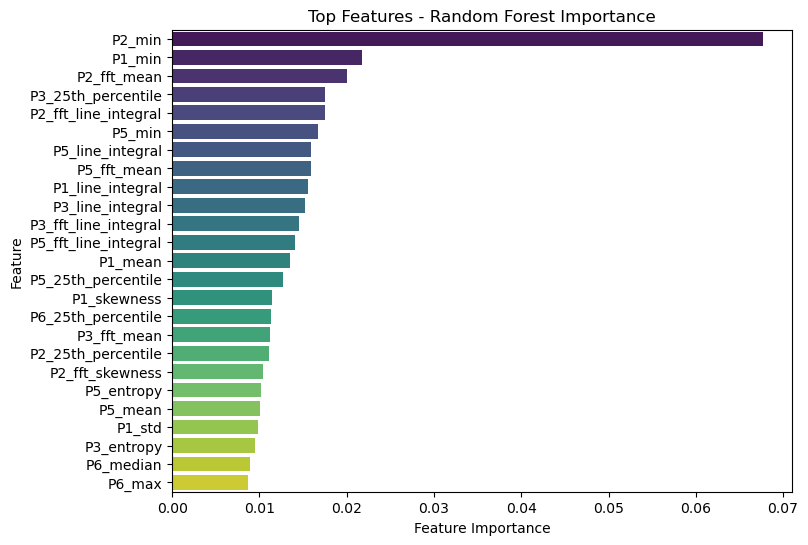

In [655]:
features_chi2 = feature_selection_random_forest(df_train,df_labels["opening_ratio"],25)


In [656]:
# features_anova= feature_selection_anova(df_train,df_labels["fault_sv"],df_labels["opening_ratio"],20)


In [657]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1,0,100
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1,0,100
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1,0,100
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,0,100


In [658]:
df_train = df_train[features_chi2]
df_test = df_test[features_chi2]
df_train = df_train[105:]
df_labels = df_labels[105:]

In [659]:
# df_train["sv"] = df_labels["fault_sv"]

In [660]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_labels["opening_ratio"], test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 15.116666666666667


In [661]:
print(y_pred)
print(y_test)

[-11.9375   116.71875   57.796875  -8.171875   9.59375   92.046875
  45.375     55.359375 -25.578125 118.953125  31.6875    73.046875
  48.640625  53.34375   37.8125  ]
109      0
167    100
123     50
105      0
133      0
155    100
115     50
139     50
117      0
159    100
152     75
136     75
114     25
150     25
110     25
Name: opening_ratio, dtype: int64


In [662]:
df_test

,P2_min,P1_min,P2_fft_mean,P3_25th_percentile,P2_fft_line_integral,P5_min,P5_line_integral,P5_fft_mean,P1_line_integral,P3_line_integral,...,P6_25th_percentile,P3_fft_mean,P2_25th_percentile,P2_fft_skewness,P5_entropy,P5_mean,P1_std,P3_entropy,P6_median,P6_max
0,0.892153,0.371555,0.782915,0.506574,0.804904,0.048438,0.055201,0.945694,0.079321,0.284698,...,0.767578,0.716499,0.039488,0.696309,0.510393,0.054306,0.899719,0.513437,0.736294,0.260942
1,0.007976,0.182168,0.648990,0.488574,0.678547,0.003761,0.130994,0.868727,0.143726,0.276441,...,0.748383,0.723817,0.046077,0.632379,0.514892,0.131273,0.965394,0.532491,0.469243,0.404429
2,0.014128,0.152192,0.823154,0.585047,0.864072,0.002697,0.069548,0.930311,0.148848,0.235622,...,0.763002,0.764304,0.056646,0.455493,0.542544,0.069689,0.996695,0.353938,0.537472,0.327367
3,0.014086,0.162786,0.820866,0.568507,0.876232,0.018448,0.186084,0.813733,0.152639,0.237975,...,0.760070,0.761930,0.042924,0.464602,0.537476,0.186267,0.996463,0.345867,0.548393,0.305438
4,0.014132,0.152803,0.817657,0.595133,0.858990,0.002987,0.071468,0.928365,0.146502,0.235478,...,0.765790,0.764450,0.056385,0.449128,0.544531,0.071635,0.996230,0.359536,0.554077,0.326308
5,0.014342,0.152057,0.821007,0.591172,0.862147,0.003052,0.077004,0.922808,0.138308,0.244589,...,0.740023,0.755367,0.058526,0.457566,0.511642,0.077192,0.996079,0.358995,0.518092,0.330976
6,1.726244,1.861598,1.437725,8.150503,1.508961,1.884693,86.454785,1.772154,128.022406,41.984366,...,5.516503,1.096219,17.693374,0.662373,-0.883680,86.581226,1.215672,-0.219376,9.293408,0.937018
7,0.014342,0.152060,0.824442,0.592538,0.865472,0.002945,0.102089,0.897716,0.137160,0.243177,...,0.747665,0.756777,0.059840,0.459112,0.509608,0.102284,0.996862,0.358034,0.591944,0.336998
8,0.036904,0.307737,0.790444,0.619198,0.829630,0.592579,0.156484,0.849976,0.052874,0.274434,...,0.711443,0.728545,0.162470,0.511675,0.693182,0.150024,0.659488,0.486745,0.417311,0.427202
9,0.014222,0.152046,0.818709,0.610076,0.859605,0.002757,0.134594,0.865208,0.141022,0.239131,...,0.759956,0.760793,0.053632,0.459471,0.504743,0.134792,0.997281,0.358100,0.532877,0.326351


In [663]:
pred=model.predict(df_test)

In [664]:
pred=pred.astype(str)

risultati non corretti.
Da modificare.

In [665]:
pred[[0,2,3,4,8,7]]

array(['98.421875', '68.078125', '53.859375', '65.6875', '100.09375',
       '58.265625'], dtype='<U32')